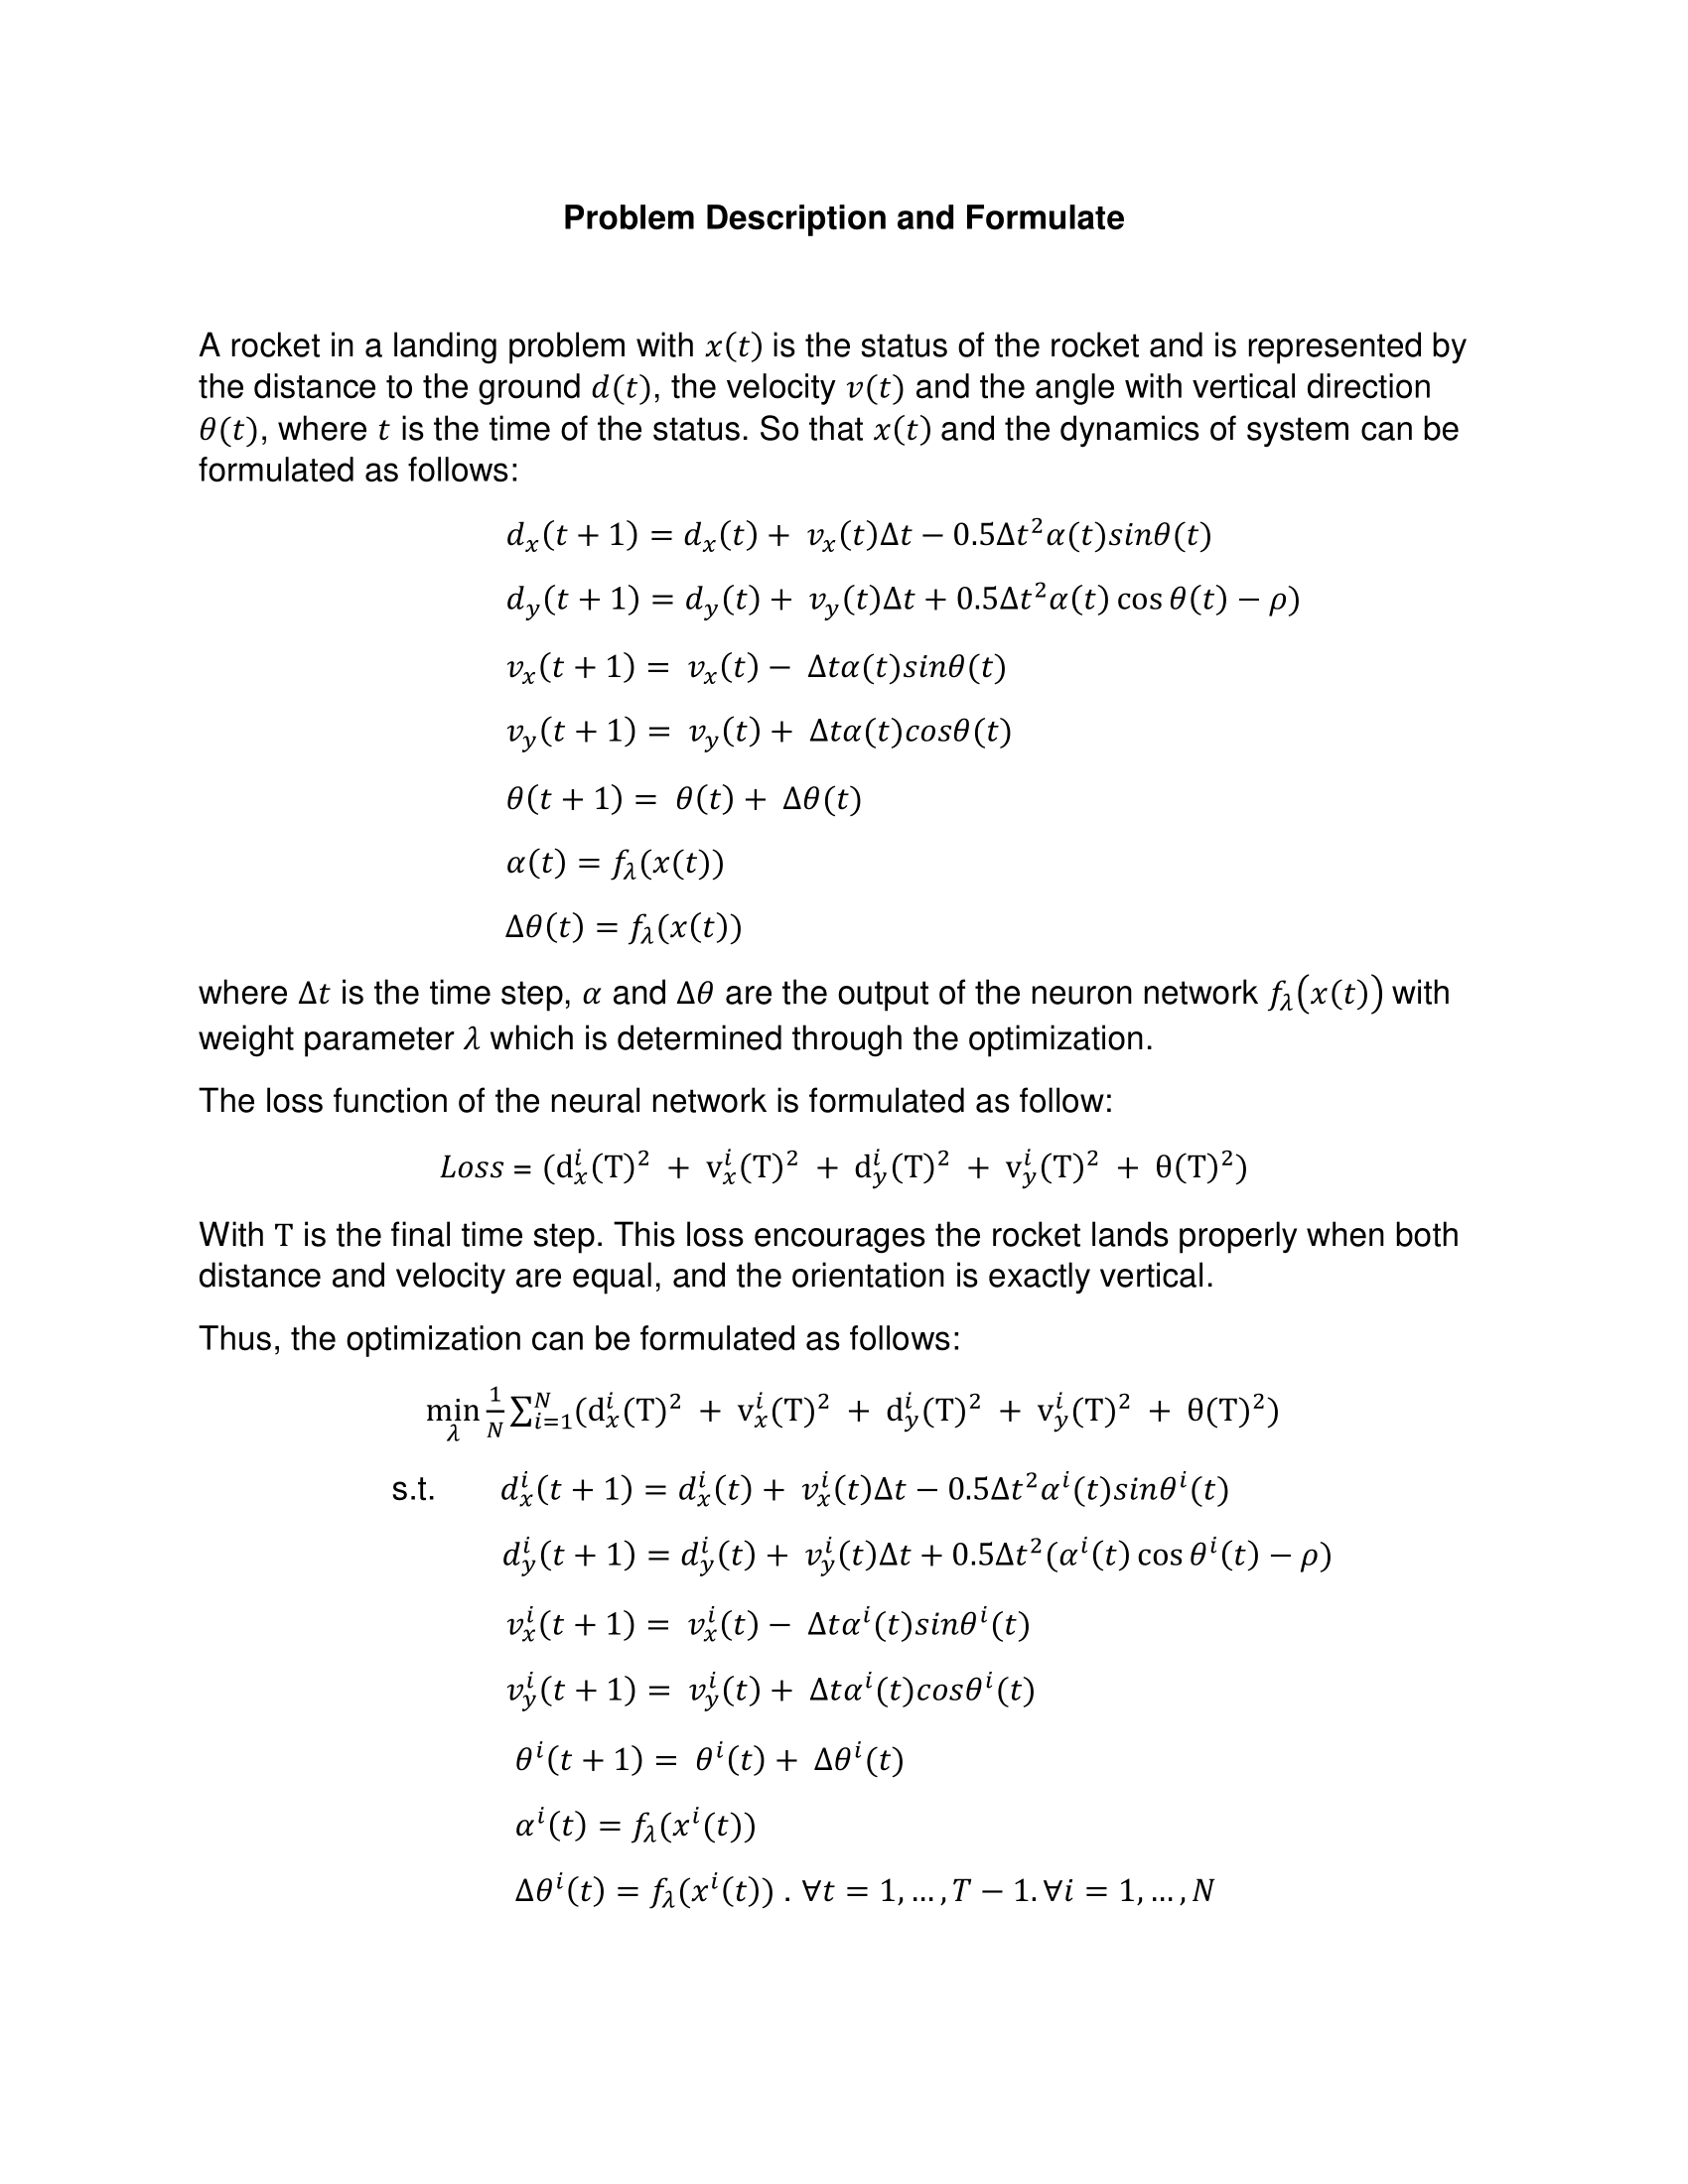

In [70]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [71]:
import logging
import math
import random
import numpy as np
import time
import torch
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import scipy.io

logger = logging.getLogger(__name__)

# Enviroment Parameters

In [72]:
PLATFORM_WIDTH = 0.25  # landing platform width
PLATFORM_HEIGHT = 0.06  # landing platform height
FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant
ROTATION_ACCEL = 20  # rotation constant
DRAG_ACCEL = 0.005  # drag constant

# Dynamics

In [93]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):

        delta_state_gravity = torch.tensor([0., 0., 0., -GRAVITY_ACCEL * FRAME_TIME, 0.])

        N = len(state)
        state_tensor = torch.zeros((N, 5))
        state_tensor[:, 1] = -torch.sin(state[:, 4])
        state_tensor[:, 3] = torch.cos(state[:, 4])
        delta_state = BOOST_ACCEL * FRAME_TIME * torch.mul(state_tensor, action[:, 0].reshape(-1, 1))

        # Theta
        delta_state_theta = FRAME_TIME * torch.mul(torch.tensor([0., 0., 0., 0, -1.]), action[:, 1].reshape(-1, 1))

        state = state + delta_state + delta_state_gravity + delta_state_theta

        # Update state
        step_mat = torch.tensor([[1., FRAME_TIME, 0., 0., 0.],
                                 [0., 1., 0., 0., 0.],
                                 [0., 0., 1., FRAME_TIME, 0.],
                                 [0., 0., 0., 1., 0.],
                                 [0., 0., 0., 0., 1.]])

#         # Noise
#         w = torch.tensor([1,0,0,0,0]) * torch.tensor(np.random.normal(mean, variance, 1))
#         u = torch.tensor([0,1,0,0,0]) * torch.tensor(np.random.normal(mean, variance, 1))
#         t = torch.tensor([0,0,1,0,0]) * torch.tensor(np.random.normal(mean, variance, 1))
#         h = torch.tensor([0,0,0,1,0]) * torch.tensor(np.random.normal(mean, variance, 1))
#         k = torch.tensor([0,0,0,0,1]) * torch.tensor(np.random.normal(mean, variance, 1))
#         noise = w + u
        
#         if Noise == True:
#             state = torch.matmul(step_mat, state.T) + noise.float()
#         else:

        state = torch.matmul(step_mat, state.T)
            

        return state.T

# Controller

In [94]:
class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: 
        """
        super(Controller, self).__init__()
        # little linear network with ReLU for embeddings
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        return action

# Simulation

In [95]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T, N):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.N = N
        self.theta_trajectory = torch.empty((1, 0))
        self.u_trajectory = torch.empty((1, 0))
#         self.is_Noise = is_Noise

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        # state = [1., 0.]  # TODO: need batch of initial states
        state = torch.rand((N, 5))
        state[:, 1] = 0  # vx = 0
        state[:, 3] = 0  # vy = 0
        # TODO: need batch of initial states
        return torch.tensor(state, requires_grad=False).float()

    def error(self, state):
        return torch.mean(state ** 2)

# Optimization

In [96]:
class Optimize:

    
    # create properties of the class (simulation, parameters, optimizer, lost_list). Where to receive input of objects
    
    def __init__(self, simulation):
        self.simulation = simulation # define the objective function
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01) # define the opmization algorithm
        self.loss_list = []

    # Define loss calculation method for objective function
    
    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)  # calculate the loss of objective function
            self.optimizer.zero_grad()
            loss.backward() # calculate the gradient
            return loss

        self.optimizer.step(closure)
        return closure()

    # Define training method for the model
    

    def train(self, epochs):
        l = np.zeros(epochs)
        for epoch in range(epochs):
            loss = self.step() # use step function to train the model
            self.loss_list.append(loss) # add loss to the loss_list
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            
            l[epoch]=loss
            
        plt.plot(list(range(epochs)), l)
            
        plt.title('Objective Function Convergence Curve')
        plt.xlabel('Training Iteration')
        plt.ylabel('Error')

        plt.show()
        
        self.visualize()
        
        
    # Define result visualization method

    def visualize(self):
        data = np.array([[self.simulation.state_trajectory[i][N].detach().numpy() for i in range(self.simulation.T)] for N in range(self.simulation.N)])
        for i in range(self.simulation.N):
            x = data[i, :, 0]  # x position
            y = data[i, :, 2]  # y position
            vx = data[i, :, 1] # Velocity in x direction
            vy = data[i, :, 3] # Velocity in x direction
            
            plt.plot(vy, y)
        plt.title('Position and Velocity Changeable for Rocket Landing')
        plt.xlabel('Rocket Velocity in y direction(m/s)')
        plt.ylabel('Rocket in y position(m)')
        plt.show()
        
        data = np.array([[self.simulation.state_trajectory[i][N].detach().numpy() for i in range(self.simulation.T)] for N in range(self.simulation.N)])
        for i in range(self.simulation.N):
            
            plt.plot(vx, y)
        plt.title('Position and Velocity Changeable for Rocket Landing')
        plt.xlabel('Rocket Velocity in x direction(m/s)')
        plt.ylabel('Rocket in y position(m)')
        plt.show()
        
        data = np.array([[self.simulation.state_trajectory[i][N].detach().numpy() for i in range(self.simulation.T)] for N in range(self.simulation.N)])
        for i in range(self.simulation.N):
            
            plt.plot(range(self.simulation.T), y)
        plt.title('Position and Time Step for Rocket Landing')
        plt.xlabel('Time Step(s)')
        plt.ylabel('Rocket in y position(m)')
        plt.show()

# Result with 10 intial states

<ipython-input-95-f6c2c96f1617>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(state, requires_grad=False).float()


[1] loss: 3.030
[2] loss: 1.642
[3] loss: 1.114
[4] loss: 0.850
[5] loss: 0.681
[6] loss: 0.549
[7] loss: 0.431
[8] loss: 0.323
[9] loss: 0.227
[10] loss: 0.159
[11] loss: 0.115
[12] loss: 0.088
[13] loss: 0.071
[14] loss: 0.058
[15] loss: 0.049
[16] loss: 0.044
[17] loss: 0.040
[18] loss: 0.038
[19] loss: 0.035
[20] loss: 0.034
[21] loss: 0.032
[22] loss: 0.031
[23] loss: 0.031
[24] loss: 0.030
[25] loss: 0.030
[26] loss: 0.029
[27] loss: 0.029
[28] loss: 0.029
[29] loss: 0.029
[30] loss: 0.029


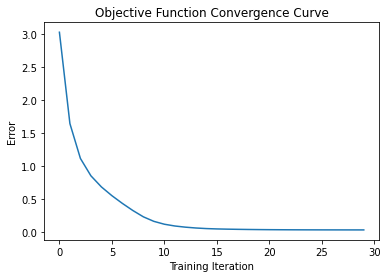

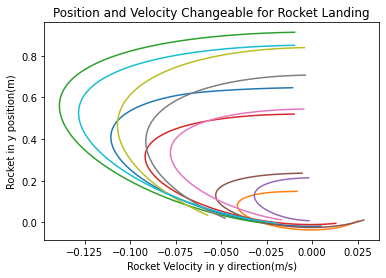

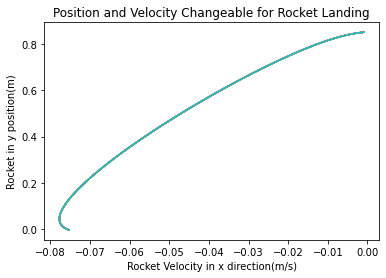

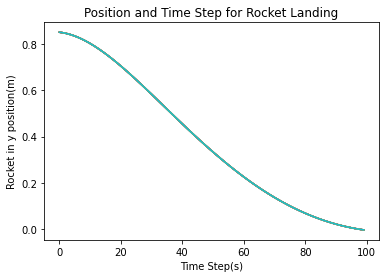

In [97]:
N = 10  # number of samples  for intinal state
T = 100  # number of time steps
dim_input = 5  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  
c = Controller(dim_input, dim_hidden, dim_output)  
s = Simulation(c, d, T, N)  
o = Optimize(s)  
o.train(30)  # training with number of epochs


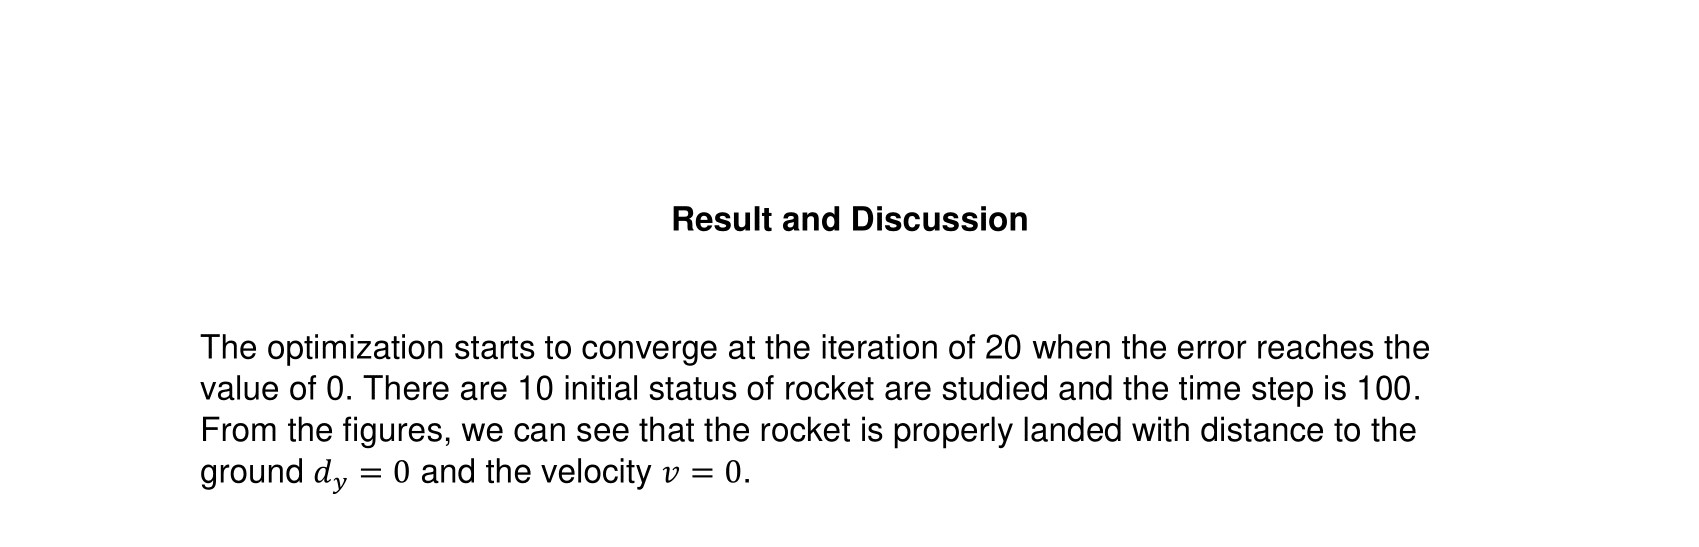